In [1]:
# from dataloader import CircleDataset, CircleRaw
from DETR_model import DinoDetrMaskMul
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from polygon import RasLoss, SoftPolygon
from tenLoader import RandRawset, TenVideoInfer, TenDataset, TenRawset

In [2]:
raw_set = RandRawset()
data_set = TenDataset(raw_set)
batch_size = 1
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True)

In [3]:
model = DinoDetrMaskMul(True)

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main
/work3/s232248/miniconda3/envs/ras/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [4]:
(
    video_idx,
    pre_idx,
    fir_img,
    fir_bou,
    fir_sgm,
    pre_img,
    pre_bou,
    pre_sgm,
    cur_img,
    cur_bou,
    cur_sgm,
) = next(iter(data_loader))
pre_idx, cur_img.shape, cur_sgm.shape

(tensor([6]), torch.Size([1, 3, 224, 224]), torch.Size([1, 224, 224]))

In [5]:
model_infer = TenVideoInfer(raw_set, is_detr=True)

In [6]:
model_infer.infer_model(model, 0)

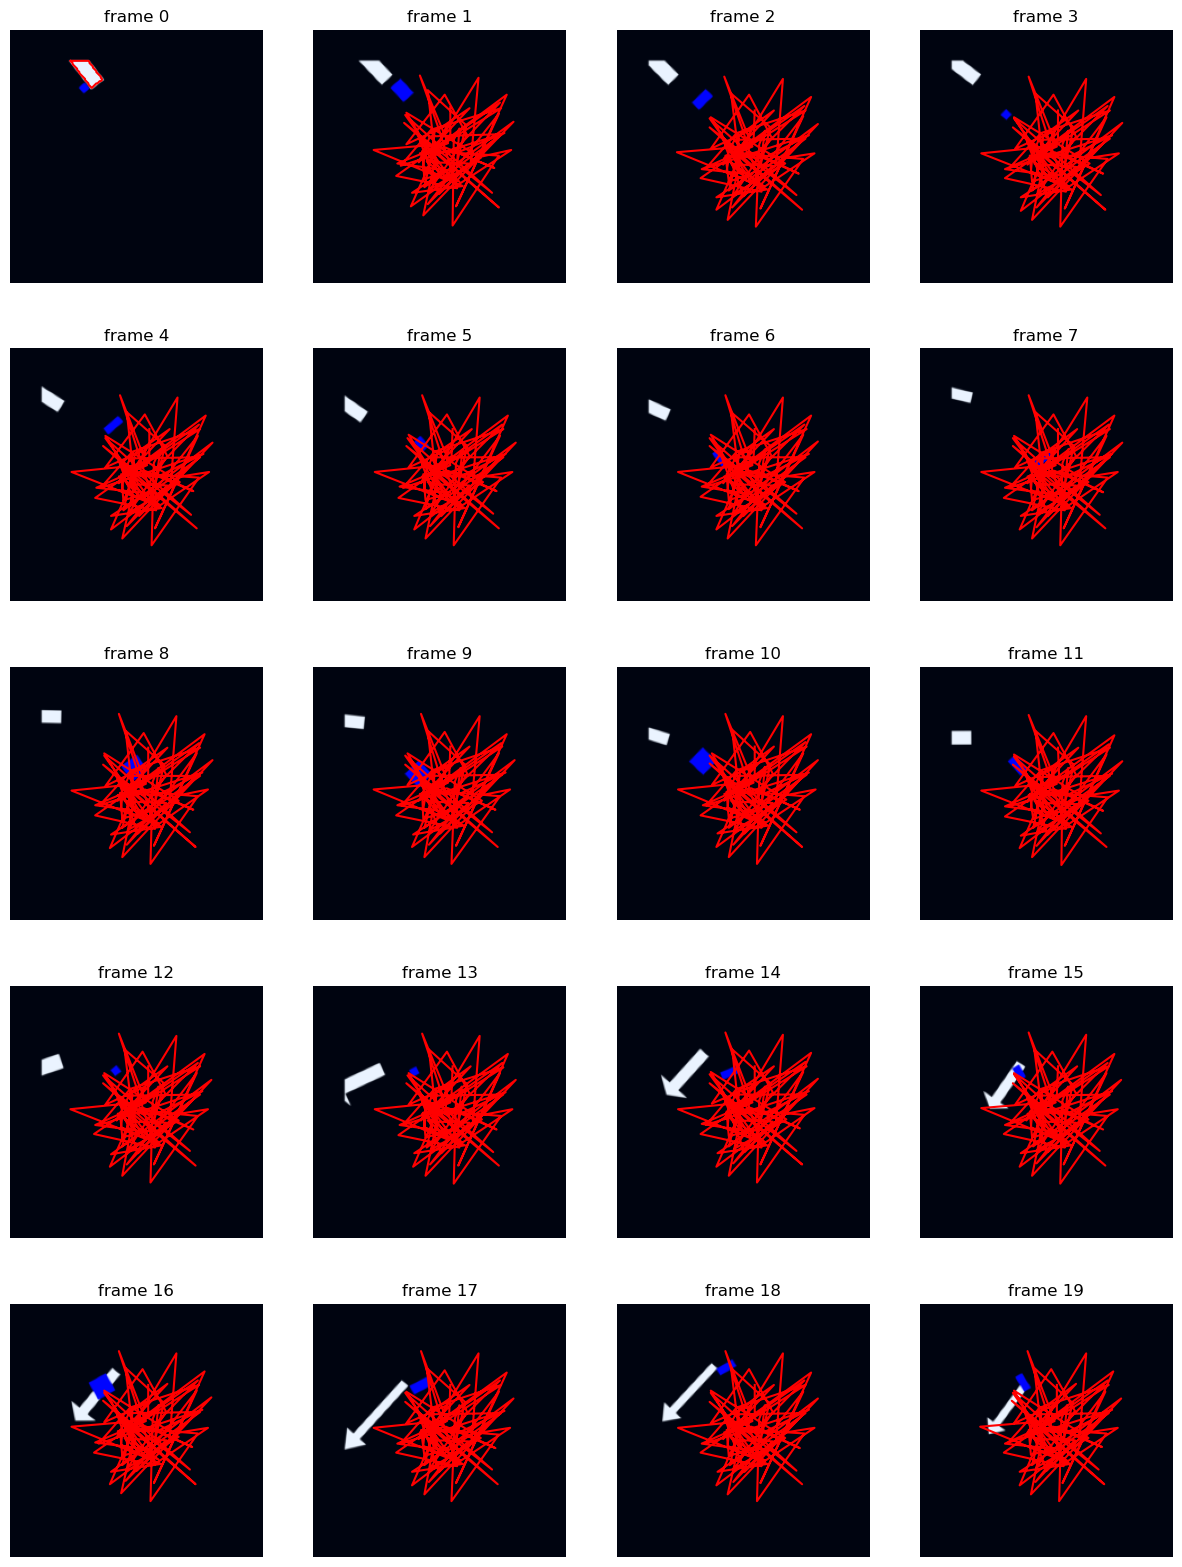

In [7]:
plt.style.use("default")
model_infer.show_infer_result(1, 0)

In [8]:
model(
    fir_img.cuda(),
    fir_sgm.cuda(),
    pre_img.cuda(),
    pre_sgm.cuda(),
    cur_img.cuda(),
).shape

torch.Size([1, 80, 2])

In [19]:
model = DinoDetrMaskMul(True).cuda()
ras_loss = RasLoss()
# raw_set = TenRawset()
raw_set = RandRawset()
model_infer = TenVideoInfer(raw_set, is_detr=True)
data_set = TenDataset(raw_set)
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True)

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main
/work3/s232248/miniconda3/envs/ras/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [20]:
loss_dict = {}
iou_dict = {}
interval_epochs = 50
inter_num = 42
epoch_index = 0
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [21]:
for interval in range(inter_num):
    for e in range(interval_epochs):
        model.train()
        mean_loss = 0
        for (
            video_idx,
            pre_idx,
            fir_img,
            fir_bou,
            fir_sgm,
            pre_img,
            pre_bou,
            pre_sgm,
            cur_img,
            cur_bou,
            cur_sgm,
        ) in data_loader:
            optimizer.zero_grad()
            pred_bou = model(
                fir_img.cuda(),
                fir_sgm.cuda(),
                pre_img.cuda(),
                pre_sgm.cuda(),
                cur_img.cuda(),
            )
            loss = ras_loss(pred_bou, cur_sgm.cuda())
            loss.backward()
            optimizer.step()
            mean_loss += loss.item()
        mean_loss /= len(data_loader)
        loss_dict[epoch_index] = mean_loss
        print(f"Epoch {epoch_index} Loss: {mean_loss}")
        epoch_index += 1
        raw_set.reset()
    model_infer.infer_model(model, 0)
    total_iou = model_infer.get_total_iou()
    iou_dict[epoch_index] = total_iou
    print(f"Epoch {epoch_index} IOU: {total_iou}")
    model_infer.show_infer_result(0, 0)
    break
    if interval_epochs > 50:
        interval_epochs = 50
    if interval_epochs > 20:
        interval_epochs -= 10
            
            

Epoch 0 Loss: 0.8786639348456734
Epoch 1 Loss: 0.8544631553323645
Epoch 2 Loss: 0.8406235305886519
Epoch 3 Loss: 0.8147975046383708
Epoch 4 Loss: 0.762989573415957
Epoch 5 Loss: 0.7494500524119327
Epoch 6 Loss: 0.7195473495282625
Epoch 7 Loss: 0.7129343606923756


KeyboardInterrupt: 

In [ ]:
model_infer.show_infer_result(3, 0)

KeyError: 3

<Figure size 1500x2000 with 0 Axes>